<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow2/Customise/SubclassCustom/Subclassing_custom_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model subclassing and custom training loops

 ## Coding tutorials
 #### [1. Model subclassing](#coding_tutorial_1)
 #### [2. Custom layers](#coding_tutorial_2)
 #### [3. Automatic differentiation](#coding_tutorial_3)
 #### [4. Custom training loops](#coding_tutorial_4)
 #### [5. tf.function decorator](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Model subclassing

#### Create a simple model using the model subclassing API

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")

# Build the model
class MyModel(tf.keras.Model):
    def __init__(self, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.dense_1 = tf.keras.layers.Dense(units=64,
            activation=tf.keras.activations.relu)
        self.dense_2 = tf.keras.layers.Dense(units=10,
            activation=tf.keras.activations.relu)
        self.dense_3 = tf.keras.layers.Dense(units=num_classes,
            activation=tf.keras.activations.softmax)
        self.dropout = tf.keras.layers.Dropout(rate=0.4)

    def call(self, inputs, training=True):
        x1 = self.dense_1(inputs=inputs)
        x2 = self.dense_2(inputs=inputs)
        concat = tf.keras.layers.Concatenate()([x1, x2])
        concat = self.dropout(inputs=concat, training=training)
        return self.dense_3(inputs=concat)

# Print the model summary
my_model = MyModel(num_classes=5, name="my_model")
my_model(inputs=tf.random.normal(shape=(1, 10)))
my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  704       
                                                                 
 dense_1 (Dense)             multiple                  110       
                                                                 
 dense_2 (Dense)             multiple                  375       
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
Total params: 1189 (4.64 KB)
Trainable params: 1189 (4.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


***
<a id="coding_tutorial_2"></a>
## Custom layers

#### Create custom layers

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")

# Create a custom layer to accumulate means of output values
class MyLayerMean(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        # Specify trainable weights
        self.b = self.add_weight(shape=(units,),
            initializer=tf.keras.initializers.Zeros())
        self.sum_activation = tf.Variable(
            initial_value=tf.zeros(shape=(units,)),
            trainable=False)
        self.number_call = tf.Variable(initial_value=0,
            trainable=False)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
            initializer=tf.keras.initializers.RandomNormal())

    def call(self, inputs):
        activations = tf.linalg.matmul(a=inputs, b=self.w) + self.b
        self.sum_activation.assign_add(delta=tf.math.reduce_sum(
            input_tensor=activations, axis=0))
        self.number_call.assign_add(delta=inputs.shape[0])
        return activations, self.sum_activation / tf.cast(
                x=self.number_call, dtype=tf.float32)

dense_layer = MyLayerMean(units=3)

# Test the layer
x = tf.ones(shape=(2, 5))
y, activation_means = dense_layer(inputs=x)
print("trainable weights:", len(dense_layer.trainable_weights))
print("non-trainable weights:", len(dense_layer.non_trainable_weights))
print(f"activation_means: {activation_means.numpy()}")
print(f"weights: {dense_layer.weights}")

trainable weights: 2
non-trainable weights: 2
activation_means: [ 0.01885552 -0.07703885 -0.2915517 ]
weights: [<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>, <tf.Variable 'my_layer_mean/Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[-0.02358919, -0.01442928, -0.0221293 ],
       [ 0.06809177, -0.09231842, -0.06502789],
       [ 0.01064425,  0.0060349 , -0.04163619],
       [-0.0387267 ,  0.03659106, -0.10442163],
       [ 0.00243539, -0.01291711, -0.05833671]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([ 0.03771103, -0.1540777 , -0.5831034 ], dtype=float32)>, <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=2>]


#### Implement the custom layers into a model

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")

# Build the model using custom layers with the model subclassing API
class MyModel(tf.keras.Model):
    def __init__(self, units_1, units_2, units_3, **kwargs):
        super().__init__(**kwargs)
        # Define layers
        self.layer_1 = MyLayer(units=units_1)
        self.layer_2 = MyLayer(units=units_2)
        self.layer_3 = MyLayer(units=units_3)
        self.dropout = MyDropout(rate=0.5)

    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs=inputs)
        x = tf.nn.relu(features=x)
        x = self.dropout(inputs=x)
        x = self.layer_2(inputs=x)
        x = tf.nn.relu(features=x)
        x = self.dropout(inputs=x)
        x = self.layer_3(inputs=x)
        return tf.nn.softmax(logits=x)

# Create a custom layer
class MyLayer(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
      super().__init__(**kwargs)
      self.units = units
      self.b = self.add_weight(shape=(units,),
          initializer=tf.keras.initializers.Zeros())

  def build(self, input_shape):
      self.w = self.add_weight(shape=(input_shape[-1], self.units),
          initializer=tf.keras.initializers.RandomNormal())

  def call(self, inputs):
      return tf.linalg.matmul(a=inputs, b=self.w) + self.b

# Create a Dropout layer as a custom layer
class MyDropout(tf.keras.layers.Layer):
    def __init__(self, rate, **kwargs):
        super().__init__(**kwargs)
        self.rate = rate

    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(x=inputs, rate=self.rate)

# Instantiate a model object
my_model = MyModel(units_1=64, units_2=64, units_3=46, name="my_model")
print(my_model(inputs=tf.random.normal(shape=(1, 10000))))
my_model.summary()

tf.Tensor(
[[0.03964711 0.01326958 0.02763753 0.01076229 0.00946367 0.03262109
  0.01824417 0.00908988 0.06717901 0.06570987 0.01522713 0.01349179
  0.02473041 0.01732281 0.01864108 0.03071251 0.01356731 0.01164669
  0.03300926 0.00993308 0.01679034 0.01374915 0.06827164 0.02038475
  0.00887607 0.01661218 0.01125773 0.01611739 0.02482517 0.01127254
  0.00647558 0.01062837 0.01034763 0.00456736 0.05896316 0.00457546
  0.00695589 0.01401417 0.02193612 0.03387661 0.02122178 0.0189374
  0.02321725 0.03404637 0.02700517 0.01316846]], shape=(1, 46), dtype=float32)
Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_layer (MyLayer)          multiple                  640064    
                                                                 
 my_layer_1 (MyLayer)        multiple                  4160      
                                                                 
 my_layer_2 (MyLayer)

***
<a id="coding_tutorial_3"></a>
## Automatic differentiation

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")

x = tf.constant(value=[0, 1, 2, 3], dtype=tf.float32)

with tf.GradientTape() as tape:
    tape.watch(tensor=x)
    y = tf.math.reduce_sum(input_tensor=x**2)
    z = tf.math.sin(x=y)
    dz_dy, dz_dx = tape.gradient(target=z, sources=[y, x])

print(f"dz_dy: {dz_dy}")
print(f"dz_dx: {dz_dx}")

dz_dy: 0.13673722743988037
dz_dx: [0.         0.27347445 0.5469489  0.82042336]


#### Build, train and plot the linear regression model

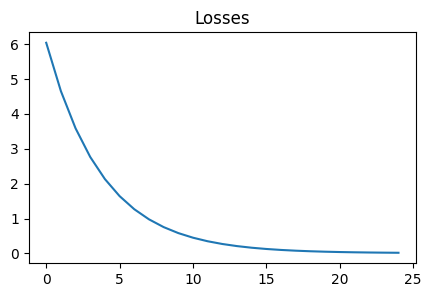

w:1,  trained w:[0.8987737]
b:2,  trained b:[1.9256457]


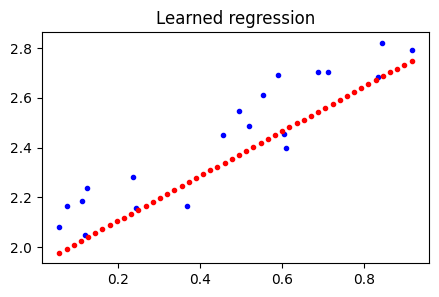

In [1]:
import numpy as np
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")
%matplotlib inline
import matplotlib.pyplot as plt

# Create data from a noise contaminated linear model
@tf.function
def MakeNoisyData(w, b, n=20):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.1)
    y = w * x + b + noise
    return x, y

w, b = 1, 2
x_train, y_train = MakeNoisyData(w=w, b=b)

# Build a custom layer for the linear regression model
class LinearLayer(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.w = self.add_weight(shape=(units,),
            initializer=tf.keras.initializers.RandomNormal())
        self.b = self.add_weight(shape=(units,),
            initializer=tf.keras.initializers.Zeros())

    def call(self, inputs):
        return self.w*inputs + self.b

linear_regression = LinearLayer(units=1)

# Define the mean squared error loss function & gradients
@tf.function
def get_loss_and_grads(x, y):
    with tf.GradientTape() as tape:
        y_pred = linear_regression(inputs=x_train)
        loss = tf.math.reduce_mean(
            input_tensor=tf.math.square(x=(y_pred-y)))
        grads = tape.gradient(target=loss,
            sources=linear_regression.trainable_variables)
    return loss, grads

# Implement a gradient descent training loop for the linear regression model
lr = 0.05
steps = 25

losses = []
for i in range(steps):
    loss, grad = get_loss_and_grads(x=x_train, y=y_train)
    losses.append(loss.numpy())
    linear_regression.w.assign_sub(delta=lr*grad[0])
    linear_regression.b.assign_sub(delta=lr*grad[1])

plt.figure(figsize=(5, 3))
plt.title(label="Losses")
plt.plot(losses)
plt.show()

# Plot the learned regression model
print("w:{},  trained w:{}".format(w, linear_regression.w.numpy()))
print("b:{},  trained b:{}".format(b, linear_regression.b.numpy()))

plt.figure(figsize=(5, 3))
plt.title(label="Learned regression")
plt.plot(x_train, y_train, 'b.')
x_linear_regression = np.linspace(start=min(x_train),
    stop=max(x_train), num=50)
y_linear_regression = linear_regression.w * x_linear_regression \
    + linear_regression.b
plt.plot(x_linear_regression, y_linear_regression, 'r.')
plt.show()

***
<a id="coding_tutorial_4"></a>
## Custom training loops

#### Load the reuters dataset and define the class_names

In [6]:
import numpy as np
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")

# Load the dataset
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.reuters.load_data(num_words=10000)

class_names = [
    'cocoa', 'grain', 'veg-oil', 'earn', 'acq', 'wheat', 'copper', 'housing',
    'money-supply', 'coffee', 'sugar', 'trade', 'reserves', 'ship', 'cotton',
    'carcass', 'crude', 'nat-gas', 'cpi', 'money-fx', 'interest', 'gnp',
    'meal-feed', 'alum', 'oilseed', 'gold', 'tin', 'strategic-metal',
    'livestock', 'retail', 'ipi', 'iron-steel', 'rubber', 'heat', 'jobs',
    'lei', 'bop', 'zinc', 'orange', 'pet-chem', 'dlr', 'gas', 'silver',
    'wpi', 'hog', 'lead'
]

# Print the class of the first sample
print("Label: {}".format(class_names[train_labels[0]]))
print("Shape of train labels:", train_labels.shape)

# Get the dataset word index
# Load the Reuters word index
word_to_index = tf.keras.datasets.reuters.get_word_index()
invert_word_index = dict([(value, key)
    for (key, value) in word_to_index.items()])

# Print the first data example sentence
text_news = ' '.join([invert_word_index.get(i - 3, '?')
    for i in train_data[0]])
print("First sample:", text_news)

# Preprocess the data
# Define a function that encodes the data
# into a 'bag of words' representation
def bag_of_words(text_samples, elements=10000):
    output = np.zeros(shape=(len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(text_samples=train_data)
print("Shape of x_train:", x_train.shape)
# Create a Dataset object for the train set
train_dataset = tf.data.Dataset.from_tensor_slices(
    tensors=(x_train, train_labels))
train_dataset = train_dataset.batch(batch_size=32)
print("Train dataset element spec:", train_dataset.element_spec)

x_test = bag_of_words(text_samples=test_data)
print("Shape of x_test:", x_test.shape)
# Create a Dataset object for the test set
test_dataset = tf.data.Dataset.from_tensor_slices(
    tensors=(x_test, test_labels))
test_dataset = test_dataset.batch(batch_size=32)
print("Test dataset element spec:", test_dataset.element_spec)

Label: earn
Shape of train labels: (8982,)
First sample: ? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
Shape of x_train: (8982, 10000)
Train dataset element spec: (TensorSpec(shape=(None, 10000), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
Shape of x_test: (2246, 10000)
Test dataset element spec: (TensorSpec(shape=(None, 10000), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))


#### Build the model

In [3]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")

# Define the custom layers and model
class MyModel(tf.keras.Model):
    def __init__(self, units_1, units_2, units_3, **kwargs):
        super().__init__(**kwargs)
        # Define layers
        self.layer_1 = MyLayer(units=units_1)
        self.layer_2 = MyLayer(units=units_2)
        self.layer_3 = MyLayer(units=units_3)
        self.dropout = MyDropout(rate=0.5)

    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs=inputs)
        x = tf.nn.relu(features=x)
        x = self.dropout(inputs=x)
        x = self.layer_2(inputs=x)
        x = tf.nn.relu(features=x)
        x = self.dropout(inputs=x)
        x = self.layer_3(inputs=x)
        return tf.nn.softmax(logits=x)

class MyLayer(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.b = self.add_weight(shape=(units,),
            initializer=tf.keras.initializers.Zeros(),
            name="bias")

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
            initializer=tf.keras.initializers.RandomNormal(),
            name="kernel")

    def call(self, inputs):
        return tf.linalg.matmul(a=inputs, b=self.w) + self.b

class MyDropout(tf.keras.layers.Layer):
    def __init__(self, rate, **kwargs):
        super().__init__(**kwargs)
        self.rate = rate

    def call(self, inputs):
        # Define forwared pass for dropout layer
        return tf.nn.dropout(x=inputs, rate=self.rate)

# Instantiate the model object
model = MyModel(units_1=64, units_2=64, units_3=46)
model(inputs=tf.keras.Input(shape=(1, 10000)))
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_layer (MyLayer)          multiple                  640064    
                                                                 
 my_layer_1 (MyLayer)        multiple                  4160      
                                                                 
 my_layer_2 (MyLayer)        multiple                  2990      
                                                                 
 my_dropout (MyDropout)      multiple                  0         
                                                                 
Total params: 647214 (2.47 MB)
Trainable params: 647214 (2.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Define the loss function and optimizer



In [10]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")

# Define the categorical cross entropy loss
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
# Define the Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Collect average loss and accuracy
metric_loss = tf.keras.metrics.Mean()
metric_acc = tf.keras.metrics.SparseCategoricalAccuracy()

# Use the @tf.function decorator
@tf.function
def get_loss_wd(model, y, yhat, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.math.reduce_sum([tf.math.reduce_sum(
        tf.math.square(x=k)) for k in kernel_variables])
    return loss_fn(y_true=y, y_pred=yhat) + wd_penalty

# Define a function to compute the training and validation
@tf.function
def train(model, x, y, wd):
    with tf.GradientTape() as tape:
        pred = model(inputs=x, training=True)
        metric_acc(y_true=y, y_pred=pred)
        loss = get_loss_wd(model=model, y=y,
            yhat=pred, wd=wd)
        metric_loss(values=loss)
        grads = tape.gradient(target=loss,
            sources=model.trainable_variables)
    optimizer.apply_gradients(grads_and_vars=zip(
        grads, model.trainable_weights))
    return metric_loss.result(), metric_acc.result()

@tf.function
def valid(model, x, y):
    pred = model(inputs=x, training=False)
    metric_acc(y_true=y, y_pred=pred)
    loss = loss_fn(y_true=y, y_pred=pred)
    metric_loss(values=loss)
    return metric_loss.result(), metric_acc.result()

***
<a id="coding_tutorial_5"></a>
## tf.function decorator

#### Print the autograph code

In [9]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")

# Use tf.autograph.to_code to see the generated code
print(tf.autograph.to_code(entity=train.python_function))

def tf__train(model, x, y, wd):
    with ag__.FunctionScope('train', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        with ag__.ld(tf).GradientTape() as tape:
            pred = ag__.converted_call(ag__.ld(model), (), dict(inputs=ag__.ld(x), training=True), fscope)
            ag__.converted_call(ag__.ld(metric_acc), (), dict(y_true=ag__.ld(y), y_pred=ag__.ld(pred)), fscope)
            loss = ag__.converted_call(ag__.ld(get_loss_wd), (), dict(model=ag__.ld(model), y=ag__.ld(y), yhat=ag__.ld(pred), wd=ag__.ld(wd)), fscope)
            ag__.converted_call(ag__.ld(metric_loss), (), dict(values=ag__.ld(loss)), fscope)
            grads = ag__.converted_call(ag__.ld(tape).gradient, (), dict(target=ag__.ld(loss), sources=ag__.ld(model).trainable_variables), fscope)
        ag__.converted_call(ag__.ld(optimizer).apply_gradient

#### Train the model

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")
import numpy as np
import pandas as pd
import time
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Implement the training loop
start_time = time.time()

# Keep results for plotting
history = {
    "train_loss": [], "train_accuracy": [],
    "valid_loss": [], "valid_accuracy": []
}
for _ in range(10):
    # Training loop
    for x, y in train_dataset:
        # Optimize the model
        train_loss, train_acc = train(model=model, x=x,
            y=y, wd=0.005)
    # Compute current loss
    history["train_loss"].append(train_loss.numpy())
    # Compare predicted label to actual label
    history["train_accuracy"].append(train_acc.numpy())

    # Evaluate the model
    # Loop over the test set and print scores
    for x, y in test_dataset:
        valid_loss, valid_acc = valid(model=model, x=x, y=y)
    # Compute current loss
    history["valid_loss"].append(valid_loss.numpy())
    # Compare predicted label to actual label
    history["valid_accuracy"].append(valid_acc.numpy())

# End epoch
print("Duration :{:.3f}".format(time.time() - start_time))
df_history = pd.DataFrame(history)

# Plot the learning curves
# Plot the training loss and accuracy
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(12, 8))
fig.suptitle(t="Training Metrics")
axes[1].set_xlabel(xlabel="epoch")
for ax, metric in zip(axes, ["loss", "accuracy"]):
    sns.lineplot(ax=ax, label="train", data=df_history,
        x=df_history.index, y=f"train_{metric}")
    sns.lineplot(ax=ax, label="valid", data=df_history,
        x=df_history.index, y=f"valid_{metric}")
    ax.legend(loc="best")
    ax.set_ylabel(ylabel=f"{metric}")
    ax.set_title(label=f"{metric} vs. epoch")
fig.tight_layout()
plt.show()

# # Get the model prediction for an example input
predicted_label = np.argmax(model(
    inputs=x_train[np.newaxis, 0]), axis=1)[0]
print("Prediction from the model")
print("Predict: {}".format(class_names[predicted_label]))
print("  Label: {}".format(class_names[train_labels[0]]))